In [3]:
import numpy as np
import xarray as xr
import os

# Define your region and time range
[xmin, xmax, ymin, ymax] = [334, 350, 10, 30]
[tmin, tmax] = ["1993", "2022"]

# File paths
file_path_sst = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_temp_mld1mean_m_1980_2023_0.25.nc')
file_path_uv = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_uv_mld1mean_m_1980_2023_0.25.nc')

# 1) Load and group SST data by season
ds_sst = xr.open_dataset(file_path_sst)
ds_sst['lon'] = (ds_sst['lon'] + 360) % 360
ds_sst = ds_sst.sortby('lon').sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax),time=slice(tmin,tmax)).groupby('time.season').mean(dim='time')
season_order = ['DJF', 'MAM', 'JJA', 'SON']
ds_sst = ds_sst.sel(season=season_order)
sst_seasonal = ds_sst['temp'].values

lon = ds_sst['lon'].values
lat = ds_sst['lat'].values

# 2) Load and group OSCAR (U, V) data by season
ds_uv = xr.open_dataset(file_path_uv)
ds_uv['lon'] = (ds_uv['lon'] + 360) % 360
ds_uv = ds_uv.sortby('lon').sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax),time=slice(tmin,tmax)).groupby('time.season').mean(dim='time')
season_order = ['DJF', 'MAM', 'JJA', 'SON']
ds_uv = ds_uv.sel(season=season_order)
uu_seasonal = ds_uv['unod'].values
vv_seasonal = ds_uv['vnod'].values

lonuv = ds_uv['lon'].values
latuv = ds_uv['lat'].values
LON, LAT = np.meshgrid(lonuv, latuv)

npz = np.load('sstu_1993_2022.npz', allow_pickle=True)
latc = npz["latc"]
latitudes = np.mean(latc, axis=1)  
npz = np.load('fesom_core2_fjra_mld1_m_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())

mld = npz["mldc"]
mldm=np.mean(mld.reshape(int(mld.shape[0]/12),12,mld.shape[1],mld.shape[2]), axis=0)


Keys in the npz file: KeysView(NpzFile 'fesom_core2_fjra_mld1_m_1993_2022.npz' with keys: mldc)


/tmp/ipykernel_2610185/1652798162.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


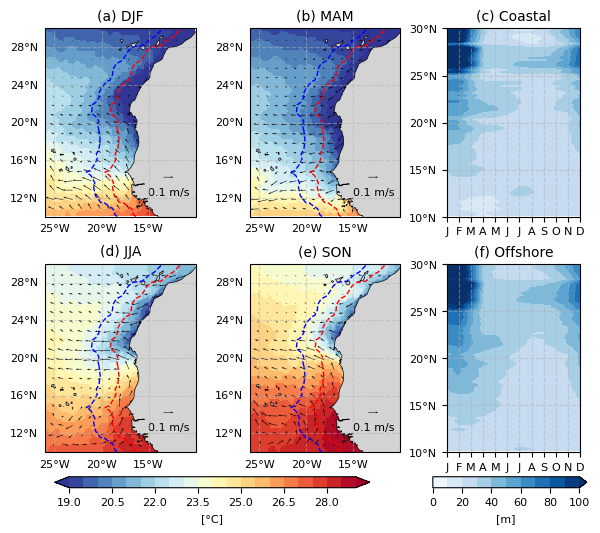

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.io.shapereader import Reader, natural_earth
from shapely.geometry import LineString

season_titles = ['(a) DJF', '(b) MAM', '(d) JJA', '(e) SON']
hov_labels = ['(c) Coastal', '(f) Offshore']
levels = np.linspace(19, 29, 21)  # Adjust to your data range as needed

# 3) Plot seasonal means
fig = plt.figure(figsize=(7, 5.5))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, .8], wspace=0.25, hspace=0.25)
plt.rcParams.update({
    "font.size": 8,
})
geo_axes = [plt.subplot(gs[0, 0], projection=ccrs.PlateCarree()),
            plt.subplot(gs[0, 1], projection=ccrs.PlateCarree()),
            plt.subplot(gs[1, 0], projection=ccrs.PlateCarree()),
            plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())]

contours = []
skip = 4  # For quiver density
plt.rcParams.update({
    "font.size": 8,
})
for i, ax in enumerate(geo_axes):

    # -- SST Contour Fill --
    contour = ax.contourf(
        lon, lat,
        sst_seasonal[i, :, :],
        levels=levels,
        cmap='RdYlBu_r',
        extend='both',
        transform=ccrs.PlateCarree()
    )
    contours.append(contour)

    # -- Quiver (U, V) --
    quiver = ax.quiver(
        LON[3:-3:skip, 3:-3:skip],
        LAT[3:-3:skip, 3:-3:skip],
        uu_seasonal[i,3:-3:skip, 3:-3:skip],
        vv_seasonal[i,3:-3:skip, 3:-3:skip],
        transform=ccrs.PlateCarree(),
        scale=1.5,
        color="black",
        linewidth=1.5
    )
    ax.quiverkey(quiver, X=0.82, Y=0.21, U=0.1,
             label='0.1 m/s', labelpos='S',
             coordinates='axes',zorder=1)
    
    ax.coastlines(linewidth=0.5)
    ax.set_title(season_titles[i], fontsize=10)
    shapefile_path = natural_earth(category='physical', name='coastline', resolution='110m')
    reader = Reader(shapefile_path)
    for record in reader.records():
        geometry = record.geometry
        if isinstance(geometry, LineString) and geometry.length > 10.0:
            coords = [
                (x, y) for x, y in geometry.coords
                if xmin-360 <= x <= xmax-360+1 and ymin <= y <= ymax+1
            ]
            if coords:
                lons, lats = zip(*coords)
                ax.plot([lon - 2 for lon in lons], lats, transform=ccrs.PlateCarree(),
                        color='red', linestyle='--', linewidth=1)
                ax.plot([lon - 4 for lon in lons], lats, transform=ccrs.PlateCarree(),
                        color='blue', linestyle='--', linewidth=1)
    ax.set_extent([xmin-360, xmax-360, ymin, ymax], crs=ccrs.PlateCarree())


    # Gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle="--", alpha=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {"fontsize": 8}
    gl.xlocator = mticker.MultipleLocator(5)
    gl.ylocator = mticker.MultipleLocator(4)

    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=1)


# Colorbar for maps
cbar_ax1 = fig.add_axes([0.15, 0.045, 0.45, 0.02])  # [left, bottom, width, height]
cbar1 = fig.colorbar(contours[0], cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('[°C]', fontsize=8)

lat_min, lat_max = 10, 30
lat_mask = (latitudes >= lat_min) & (latitudes <= lat_max)
latitudes_subset = latitudes[lat_mask]

datasets = [mldm[:,:,8:], mldm[:,:,0:]]
cl = [100, 100]
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
hov_axes = [plt.subplot(gs[0, 2]), plt.subplot(gs[1, 2])]
contour_hov = []

for i, ax in enumerate(hov_axes):
    hov_data = np.nanmean(datasets[i], axis=-1)
    hov_data_subset = hov_data[:, lat_mask]

    levels = np.linspace(0, cl[i], 11)
    c = ax.contourf(np.arange(12), latitudes_subset, hov_data_subset.T, levels=levels,
                    cmap='Blues', extend='max')
    contour_hov.append(c)

    ax.set_title(hov_labels[i], fontsize=10)
    ax.set_xticks(np.arange(12))
    ax.set_xticklabels(month_labels, fontsize=8)
    ax.set_ylim(lat_min, lat_max)
    ax.set_yticks(np.arange(lat_min, lat_max+1, 5))
    ax.set_yticklabels([f'{int(l)}°N' for l in np.arange(lat_min, lat_max+1, 5)], fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)

# Colorbar for hovmöller
cbar_ax2 = fig.add_axes([0.69, 0.045, 0.22, 0.02])  # [left, bottom, width, height]
cbar2 = fig.colorbar(contour_hov[0], cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('[m]', fontsize=8)

plt.tight_layout()
plt.savefig("fig4.png", dpi=300, bbox_inches='tight')
plt.show()
